In [1]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path

print(Path().cwd())
os.chdir(Path(os.getcwd()).parent)
print(Path().cwd())

/Users/wuyuanshan/Desktop/Github/QuantUS-Plugins-CEUS/TwoD_CEUS_test
/Users/wuyuanshan/Desktop/Github/QuantUS-Plugins-CEUS


## Select Contrast-Enhanced Ultrasound (CEUS) Cine and Parser

In [2]:
from src.image_loading.options import get_scan_loaders

print("Available scan loaders:", list(get_scan_loaders().keys()))

Available scan loaders: ['avi', 'nifti', 'custom_dicom', 'mp4']


In [3]:
scan_type = 'mp4'

scan_path = '/Users/wuyuanshan/Desktop/Research/Post-Doc El Kaffas/ctDNA Project Samantha/Data/wk6/p14_wk6.mp4'
scan_loader_kwargs = {
    'transpose': False
}

In [4]:
from src.entrypoints import scan_loading_step

image_data = scan_loading_step(scan_type, scan_path, **scan_loader_kwargs)

## Load Segmentation

Assumes same segmentation for each frame

In [5]:
from src.seg_loading.options import get_seg_loaders

print("Available segmentation loaders:", list(get_seg_loaders().keys()))

Available segmentation loaders: ['nifti', 'load_bolus_mask']


In [6]:
seg_type = 'nifti'

seg_path = '/Users/wuyuanshan/Desktop/Research/Post-Doc El Kaffas/ctDNA Project Samantha/Data/wk6/p14_wk6_roi.nii.gz'
seg_loader_kwargs = {}

In [7]:
from src.entrypoints import seg_loading_step

seg_data = seg_loading_step(seg_type, image_data, seg_path, scan_path, **seg_loader_kwargs)

(1472, 1962)
(826, 1472, 1962, 3)


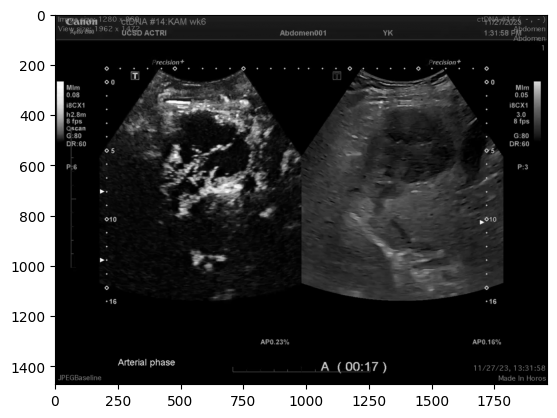

In [23]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
single_image = image_data.pixel_data[130,:,:,0]
plt.imshow(single_image,cmap='gray')
# plt.imshow(seg_data.seg_mask,alpha=0.5,cmap='Reds')

print(seg_data.seg_mask.shape)
print(image_data.pixel_data.shape)

# Generating T0 map using Segmentation Mask and Pixel data.

In [11]:
image_data.pixel_data.shape

(826, 1472, 1962, 3)

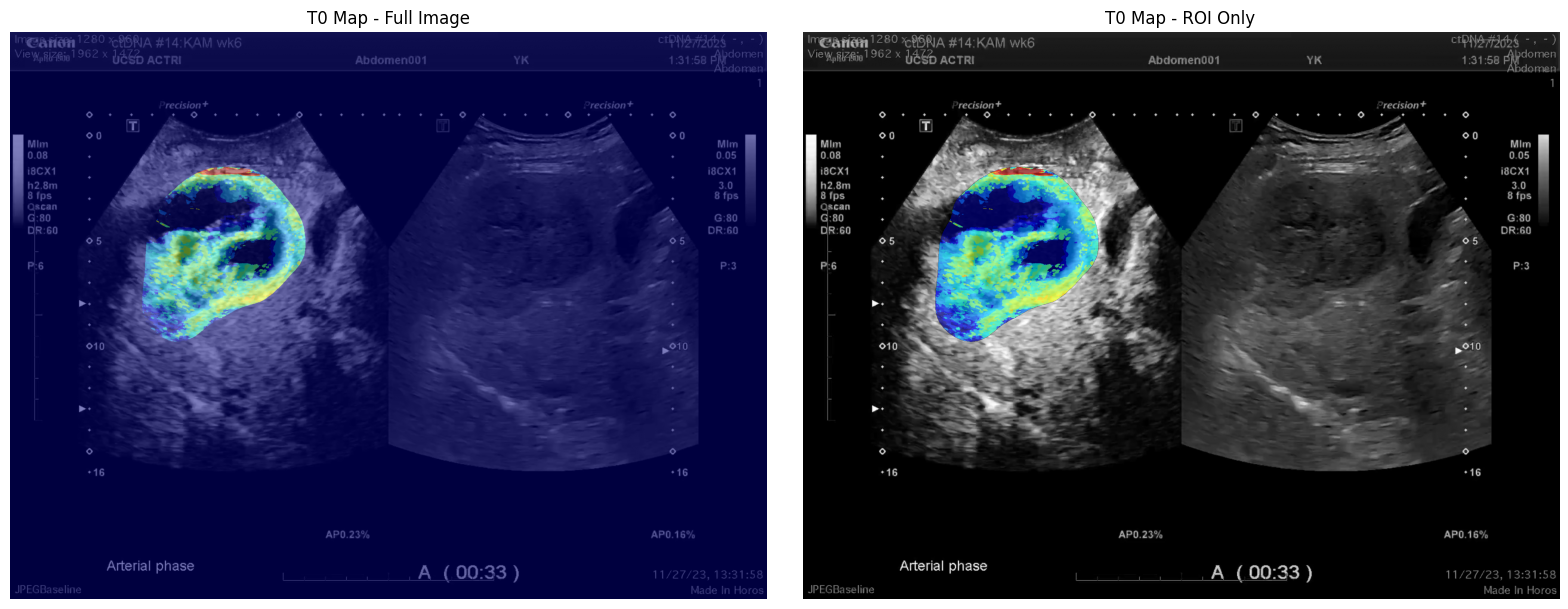


T0 Map Statistics:
  mean_t0: 51.64
  median_t0: 50.00
  std_t0: 22.52
  min_t0: 1.00
  max_t0: 140.00
  coverage: 83.22


In [30]:
from TwoD_CEUS_test.T0_map import generate_t0_map, get_t0_statistics, mask_t0_map

# Generate the T0 map
t0_map = generate_t0_map(
    image_data.pixel_data[:,:,:,0],  # Use the first channel if multi-channel
    seg_data.seg_mask,
    threshold=180,
    start_frame=50,
    end_frame=190  
)

# Mask the T0 map to show only ROI
masked_t0_map = mask_t0_map(t0_map, seg_data.seg_mask)

# Visualize it
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Original with full overlay
single_image = image_data.pixel_data[250,:,:,0]
axes[0].imshow(single_image, cmap='gray')
axes[0].imshow(t0_map, alpha=0.5, cmap='jet')
axes[0].set_title('T0 Map - Full Image')
axes[0].axis('off')

# Right: Masked to show only ROI
axes[1].imshow(single_image, cmap='gray')
axes[1].imshow(masked_t0_map, alpha=0.7, cmap='jet')
axes[1].set_title('T0 Map - ROI Only')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Get statistics
stats = get_t0_statistics(t0_map, seg_data.seg_mask)
print("\nT0 Map Statistics:")
for key, value in stats.items():
    print(f"  {key}: {value:.2f}")